In [1]:
# Loading packages
from google.colab import drive
import os
from torchvision import transforms 
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
import torch.optim as optim
import random
from tqdm.notebook import tqdm
import numpy as np

# Also, as we have a auxiliar python file with function, we go to use it
from cnn_functions import *

In [2]:
# As our dataset is mounted in Google Drive, we need to get access to it.
drive.mount('/content/drive')

# Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/DeepLearning/dataset/'
classes = os.listdir(data_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Performing Image Transformations. 
train_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [4]:
# Checking the dataset training size
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 5400


In [5]:
# Viewing one of images shape
img, label = dataset[100]
print(img.shape)

torch.Size([3, 224, 224])


In [6]:
# Setting seed so that value won't change everytime
# Splitting the dataset to training, validation, and testing category
torch.manual_seed(1)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [7]:
# Random Splitting
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
# Check the size of each dataset
len(train_ds), len(val_ds),len(test_ds)  

(4590, 270, 540)

In [8]:
# Define batch size
batch_size = 12
# Define a generator of random values
g_cpu = torch.Generator()
g_cpu.manual_seed(123)
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True,generator  = g_cpu)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

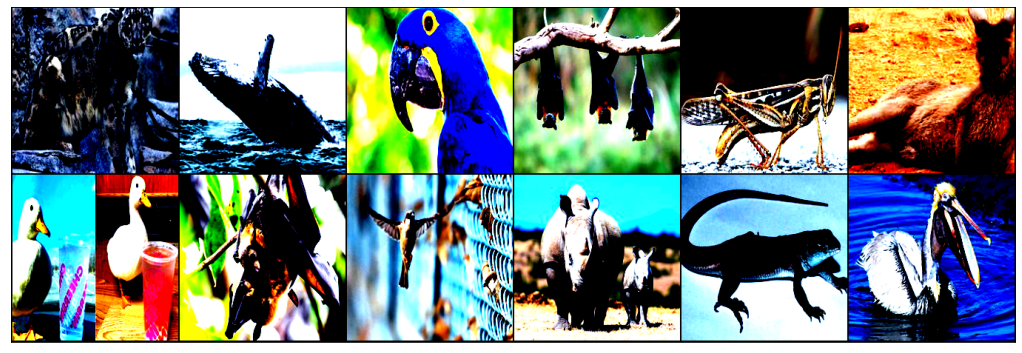

In [9]:
# We can see some of these images available in one batch
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=6).permute(1, 2, 0))
    break

In [10]:
# Now, we go to consider some parameters to start to create our models
input_size = torch.randn(1, 3, 224, 224)
output_size = 90

# Pass our data to GPU
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

# **Create GoogleNet Model**

In [11]:
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [12]:
# Reporting the Flops of this model
print_model_parm_flops(model_googlenet,input_size, detail=False)

 + Number of FLOPs: 2.97G


# **GoogleNet, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.01, epochs:20**

In [13]:
from cnn_functions import *
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [14]:
cnn_sgd_lr001_performance = fit_model(model_googlenet,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.532


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.303


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.191


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.067


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.926


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.808


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.659


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.552


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.433


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.329


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.251


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.128


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.037


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.942


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.869


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.760


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.684


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.598


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.483


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.415
Finished Training


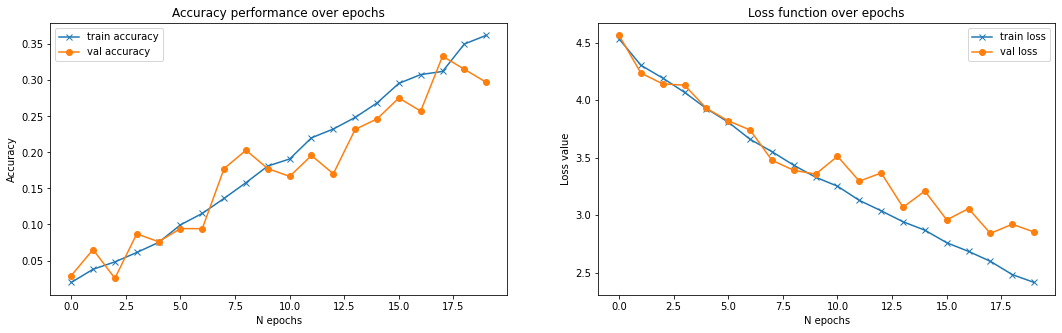

In [15]:
# Plot results
plot_performance(cnn_sgd_lr001_performance[1],cnn_sgd_lr001_performance[2])

In [16]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.30185186862945557


# **GoogleNet, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.001, epochs:20**

In [17]:
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()
cnn_sgd_lr01_performance = fit_model(model_googlenet,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.367


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.054


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.799


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.588


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.404


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.248


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.140


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.981


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.857


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.755


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.612


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.479


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.368


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.237


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.147


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.015


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.912


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.803


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.738


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.581
Finished Training


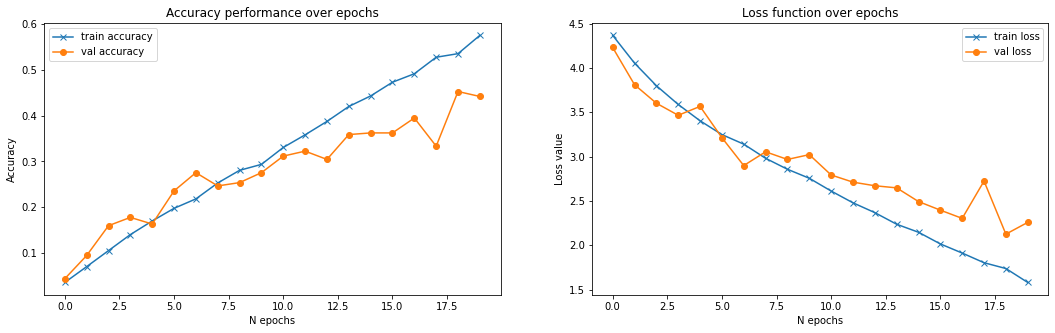

In [18]:
# Plot results
plot_performance(cnn_sgd_lr01_performance[1],cnn_sgd_lr01_performance[2])

In [19]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.45185187458992004


# **GoogleNet, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.01, epochs:20**

In [20]:
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()
cnn_adam_lr001_performance = fit_model(model_googlenet,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.742


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.439


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.362


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.315


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.293


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.216


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.141


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.070


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.038


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.995


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.922


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.881


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.850


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.776


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.721


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.697


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.631


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.536


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.488


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.441
Finished Training


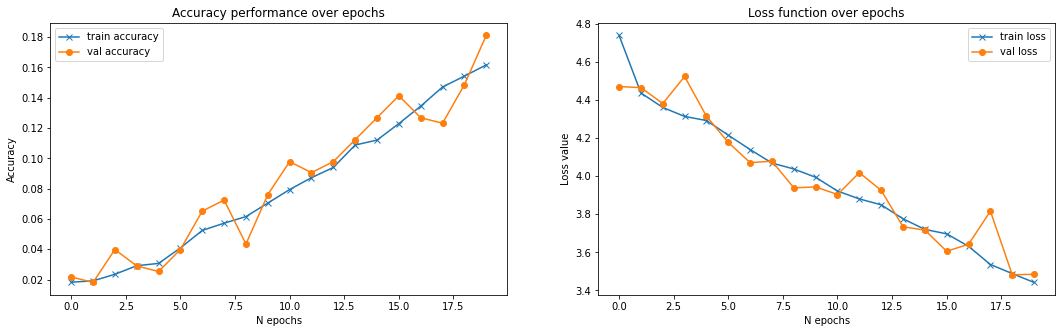

In [21]:
# Plot results
plot_performance(cnn_adam_lr001_performance[1],cnn_adam_lr001_performance[2])

In [22]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.17592595517635345


# **GoogleNet, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.001, epochs:20**

In [23]:
model_googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=False)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()
cnn_adam_lr01_performance = fit_model(model_googlenet,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.574


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.420


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.351


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.310


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.237


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.180


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.132


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.079


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.970


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.859


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.779


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.680


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.569


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.450


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.355


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.243


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.153


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.027


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.915


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.851
Finished Training


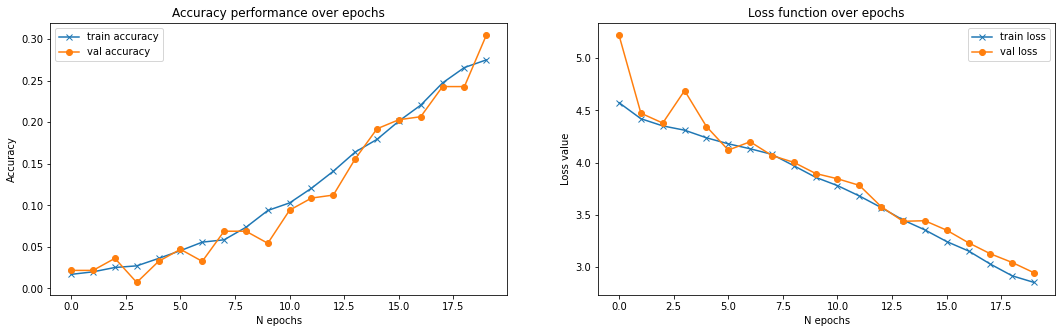

In [24]:
# Plot results
plot_performance(cnn_adam_lr01_performance[1],cnn_adam_lr01_performance[2])

In [25]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.2851852476596832


# **GoogleNet pretrained Model**

In [26]:
model_googlenet_pt = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet_pt.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

# **GoogleNet pretrained, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.01, epochs:20**

In [27]:
cnn_sgd_lr001_performance = fit_model(model_googlenet_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.090


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.520


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.106


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.748


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.564


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.455


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.292


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.221


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.181


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.144


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.143


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.126


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.110


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.102


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.075


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.052


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.052


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.028


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.032


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.029
Finished Training


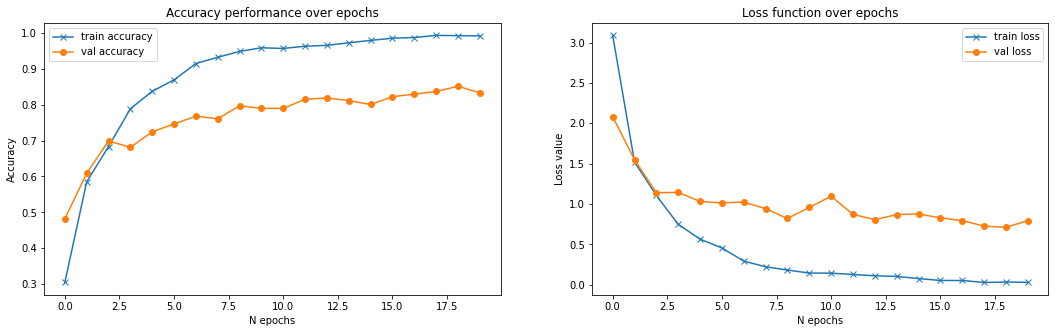

In [28]:
# Plot results
plot_performance(cnn_sgd_lr001_performance[1],cnn_sgd_lr001_performance[2])

In [29]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.8314815163612366


# **GoogleNet pretrained, Loss function: Cross entropy, Optimizer: SGD, learning rate:0.001, epochs:20**

In [30]:
model_googlenet_pt = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()
cnn_sgd_lr01_performance = fit_model(model_googlenet_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'SGD',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.340


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.625


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.856


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.545


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.362


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.261


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.200


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.158


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.121


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.106


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.086


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.071


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.057


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.052


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.048


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.041


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.037


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.040


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.035


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.033
Finished Training


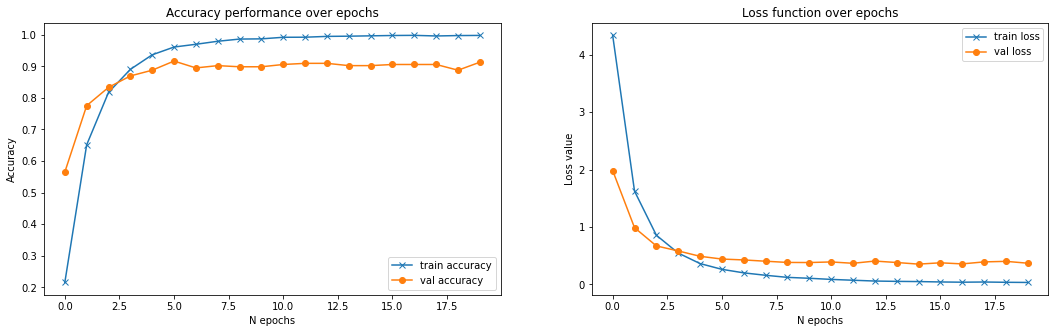

In [31]:
# Plot results
plot_performance(cnn_sgd_lr01_performance[1],cnn_sgd_lr01_performance[2])

In [32]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_sgd_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.9185184240341187


# **GoogleNet pretrained, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.01, epochs:20**

In [33]:
model_googlenet_pt = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()
cnn_adam_lr001_performance = fit_model(model_googlenet_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.01)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.749


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.371


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.250


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.205


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.131


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.080


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:4.034


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.993


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.945


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.879


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.826


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.770


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.711


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.657


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.585


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.529


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.446


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.378


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.346


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.255
Finished Training


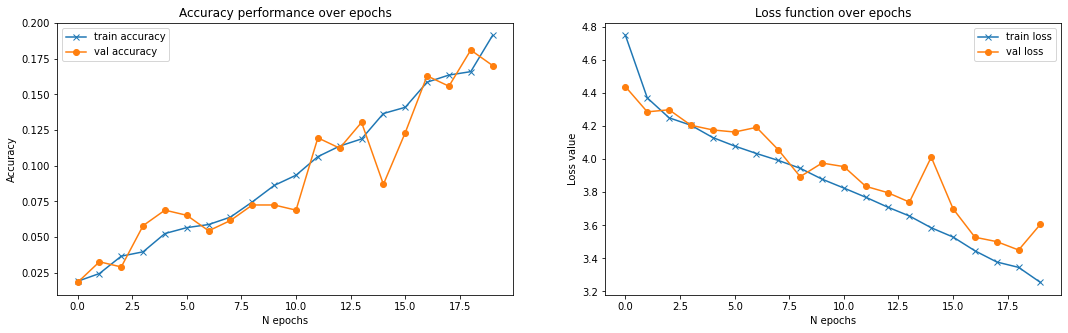

In [34]:
# Plot results
plot_performance(cnn_adam_lr001_performance[1],cnn_adam_lr001_performance[2])

In [35]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr001_performance[3][0].cpu()}')

Accuracy in testing is: 0.16296295821666718


# **GoogleNet pretrained, Loss function: Cross entropy, Optimizer: Adam, learning rate:0.001, epochs:20**

In [36]:
model_googlenet_pt = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)
model_googlenet.aux1.fc2 = nn.Linear(1024,90)
model_googlenet.aux2.fc2 = nn.Linear(1024,90)
model_googlenet.fc = nn.Linear(1024,90)
model_googlenet.eval()
cnn_adam_lr01_performance = fit_model(model_googlenet_pt,train_loader = train_loader,val_loader = val_loader,test_loader =test_loader,optimization = 'Adam',loss_function = 'Cross-entropy',epochs = 20,learning_rate = 0.001)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:3.281


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:2.050


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.575


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:1.216


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.963


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.841


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.703


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.589


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.519


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.451


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.490


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.387


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.388


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.318


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.315


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.312


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.250


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.301


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.247


  0%|          | 0/383 [00:00<?, ?it/s]

[loss in training]:0.231
Finished Training


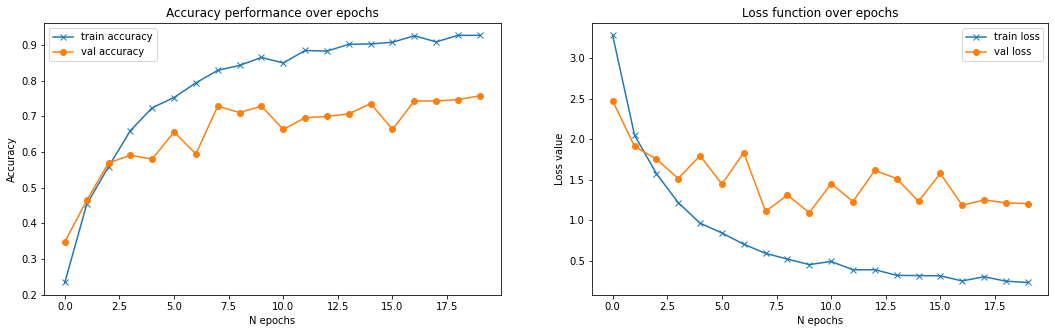

In [37]:
# Plot results
plot_performance(cnn_adam_lr01_performance[1],cnn_adam_lr01_performance[2])

In [38]:
# Reporting test accuracy
print(f'Accuracy in testing is: {cnn_adam_lr01_performance[3][0].cpu()}')

Accuracy in testing is: 0.7481482028961182
